# Hidden Markov Models for Accelerometer datasets

### Author: Baihan Lin, Columbia University
### References: scipy, numpy, hmmlearn, sklearn, matplotlib etc.

In [68]:
%matplotlib inline

Declare and import functions
--------------------------

In [93]:
import pyximport
pyximport.install()

import string
import sys
from collections import deque
from __future__ import print_function
import datetime
import json
from pprint import pprint
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from scipy.misc import logsumexp
from scipy import linalg
from sklearn import cluster
from sklearn.mixture import (
    distribute_covar_matrix_to_match_covariance_type, _validate_covars
)
from sklearn.utils import check_random_state
from sklearn.base import BaseEstimator, _pprint
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted

import _hmmc
# import hmmlearn._hmmc
# from hmmlearn.hmm import GaussianHMM
# from . import _hmmc
# import _hmmc


Define utils
------------

In [70]:
def normalize(a, axis=None):
    a_sum = a.sum(axis)
    if axis and a.ndim > 1:
        # Make sure we don't divide by zero.
        a_sum[a_sum == 0] = 1
        shape = list(a.shape)
        shape[axis] = 1
        a_sum.shape = shape

    a /= a_sum


def log_normalize(a, axis=None):
    a_lse = logsumexp(a, axis)
    a -= a_lse[:, np.newaxis]


def iter_from_X_lengths(X, lengths):
    if lengths is None:
        yield 0, len(X)
    else:
        n_samples = X.shape[0]
        end = np.cumsum(lengths).astype(np.int32)
        start = end - lengths
        if end[-1] > n_samples:
            raise ValueError("more than {0:d} samples in lengths array {1!s}"
                             .format(n_samples, lengths))

        for i in range(len(lengths)):
            yield start[i], end[i]


def log_mask_zero(a):
    a = np.asarray(a)
    with np.errstate(divide="ignore"):
        a_log = np.log(a)
        a_log[a <= 0] = 0.0
        return a_log


def fill_covars(covars, covariance_type='full', n_components=1, n_features=1):
    if covariance_type == 'full':
        return covars
    elif covariance_type == 'diag':
        return np.array(list(map(np.diag, covars)))
    elif covariance_type == 'tied':
        return np.tile(covars, (n_components, 1, 1))
    elif covariance_type == 'spherical':
        eye = np.eye(n_features)[np.newaxis, :, :]
        covars = covars[:, np.newaxis, np.newaxis]
        return eye * covars


Define _hmmc
------------

In [71]:
# # cython: boundscheck=False, wraparound=False

# from cython cimport view
# from numpy.math cimport expl, logl, log1pl, isinf, fabsl, INFINITY

# import numpy as np

# ctypedef double dtype_t


# cdef inline int _argmax(dtype_t[:] X) nogil:
#     cdef dtype_t X_max = -INFINITY
#     cdef int pos = 0
#     cdef int i
#     for i in range(X.shape[0]):
#         if X[i] > X_max:
#             X_max = X[i]
#             pos = i
#     return pos


# cdef inline dtype_t _max(dtype_t[:] X) nogil:
#     return X[_argmax(X)]


# cdef inline dtype_t _logsumexp(dtype_t[:] X) nogil:
#     cdef dtype_t X_max = _max(X)
#     if isinf(X_max):
#         return -INFINITY

#     cdef dtype_t acc = 0
#     for i in range(X.shape[0]):
#         acc += expl(X[i] - X_max)

#     return logl(acc) + X_max


# cdef inline dtype_t _logaddexp(dtype_t a, dtype_t b) nogil:
#     if isinf(a) and a < 0:
#         return b
#     elif isinf(b) and b < 0:
#         return a
#     else:
#         return max(a, b) + log1pl(expl(-fabsl(a - b)))


# def _forward(int n_samples, int n_components,
#              dtype_t[:] log_startprob,
#              dtype_t[:, :] log_transmat,
#              dtype_t[:, :] framelogprob,
#              dtype_t[:, :] fwdlattice):

#     cdef int t, i, j
#     cdef dtype_t[::view.contiguous] work_buffer = np.zeros(n_components)

#     with nogil:
#         for i in range(n_components):
#             fwdlattice[0, i] = log_startprob[i] + framelogprob[0, i]

#         for t in range(1, n_samples):
#             for j in range(n_components):
#                 for i in range(n_components):
#                     work_buffer[i] = fwdlattice[t - 1, i] + log_transmat[i, j]

#                 fwdlattice[t, j] = _logsumexp(work_buffer) + framelogprob[t, j]


# def _backward(int n_samples, int n_components,
#               dtype_t[:] log_startprob,
#               dtype_t[:, :] log_transmat,
#               dtype_t[:, :] framelogprob,
#               dtype_t[:, :] bwdlattice):

#     cdef int t, i, j
#     cdef dtype_t[::view.contiguous] work_buffer = np.zeros(n_components)

#     with nogil:
#         for i in range(n_components):
#             bwdlattice[n_samples - 1, i] = 0.0

#         for t in range(n_samples - 2, -1, -1):
#             for i in range(n_components):
#                 for j in range(n_components):
#                     work_buffer[j] = (log_transmat[i, j]
#                                       + framelogprob[t + 1, j]
#                                       + bwdlattice[t + 1, j])
#                 bwdlattice[t, i] = _logsumexp(work_buffer)


# def _compute_log_xi_sum(int n_samples, int n_components,
#                         dtype_t[:, :] fwdlattice,
#                         dtype_t[:, :] log_transmat,
#                         dtype_t[:, :] bwdlattice,
#                         dtype_t[:, :] framelogprob,
#                         dtype_t[:, :] log_xi_sum):

#     cdef int t, i, j
#     cdef dtype_t[:, ::view.contiguous] work_buffer = \
#         np.full((n_components, n_components), -INFINITY)
#     cdef dtype_t logprob = _logsumexp(fwdlattice[n_samples - 1])

#     with nogil:
#         for t in range(n_samples - 1):
#             for i in range(n_components):
#                 for j in range(n_components):
#                     work_buffer[i, j] = (fwdlattice[t, i]
#                                          + log_transmat[i, j]
#                                          + framelogprob[t + 1, j]
#                                          + bwdlattice[t + 1, j]
#                                          - logprob)

#             for i in range(n_components):
#                 for j in range(n_components):
#                     log_xi_sum[i, j] = _logaddexp(log_xi_sum[i, j],
#                                                   work_buffer[i, j])


# def _viterbi(int n_samples, int n_components,
#              dtype_t[:] log_startprob,
#              dtype_t[:, :] log_transmat,
#              dtype_t[:, :] framelogprob):

#     cdef int i, j, t, where_from
#     cdef dtype_t logprob

#     cdef int[::view.contiguous] state_sequence = \
#         np.empty(n_samples, dtype=np.int32)
#     cdef dtype_t[:, ::view.contiguous] viterbi_lattice = \
#         np.zeros((n_samples, n_components))
#     cdef dtype_t[::view.contiguous] work_buffer = np.empty(n_components)

#     with nogil:
#         for i in range(n_components):
#             viterbi_lattice[0, i] = log_startprob[i] + framelogprob[0, i]

#         # Induction
#         for t in range(1, n_samples):
#             for i in range(n_components):
#                 for j in range(n_components):
#                     work_buffer[j] = (log_transmat[j, i]
#                                       + viterbi_lattice[t - 1, j])

#                 viterbi_lattice[t, i] = _max(work_buffer) + framelogprob[t, i]

#         # Observation traceback
#         state_sequence[n_samples - 1] = where_from = \
#             _argmax(viterbi_lattice[n_samples - 1])
#         logprob = viterbi_lattice[n_samples - 1, where_from]

#         for t in range(n_samples - 2, -1, -1):
#             for i in range(n_components):
#                 work_buffer[i] = (viterbi_lattice[t, i]
#                                   + log_transmat[i, where_from])

#             state_sequence[t] = where_from = _argmax(work_buffer)

#     return np.asarray(state_sequence), logprob


Define stats
------------

In [72]:

def log_multivariate_normal_density(X, means, covars, covariance_type='diag'):
    
    log_multivariate_normal_density_dict = {
        'spherical': _log_multivariate_normal_density_spherical,
        'tied': _log_multivariate_normal_density_tied,
        'diag': _log_multivariate_normal_density_diag,
        'full': _log_multivariate_normal_density_full}
    return log_multivariate_normal_density_dict[covariance_type](
        X, means, covars
    )


def _log_multivariate_normal_density_diag(X, means, covars):
    """Compute Gaussian log-density at X for a diagonal model."""
    n_samples, n_dim = X.shape
    lpr = -0.5 * (n_dim * np.log(2 * np.pi) + np.sum(np.log(covars), 1)
                  + np.sum((means ** 2) / covars, 1)
                  - 2 * np.dot(X, (means / covars).T)
                  + np.dot(X ** 2, (1.0 / covars).T))
    return lpr


def _log_multivariate_normal_density_spherical(X, means, covars):
    """Compute Gaussian log-density at X for a spherical model."""
    cv = covars.copy()
    if covars.ndim == 1:
        cv = cv[:, np.newaxis]
    if cv.shape[1] == 1:
        cv = np.tile(cv, (1, X.shape[-1]))
    return _log_multivariate_normal_density_diag(X, means, cv)


def _log_multivariate_normal_density_tied(X, means, covars):
    """Compute Gaussian log-density at X for a tied model."""
    cv = np.tile(covars, (means.shape[0], 1, 1))
    return _log_multivariate_normal_density_full(X, means, cv)

def _log_multivariate_normal_density_full(X, means, covars, min_covar=1.e-7):
    """Log probability for full covariance matrices."""
    n_samples, n_dim = X.shape
    nmix = len(means)
    log_prob = np.empty((n_samples, nmix))
    for c, (mu, cv) in enumerate(zip(means, covars)):
        try:
            cv_chol = linalg.cholesky(cv, lower=True)
        except linalg.LinAlgError:
            # The model is most probably stuck in a component with too
            # few observations, we need to reinitialize this components
            try:
                cv_chol = linalg.cholesky(cv + min_covar * np.eye(n_dim),
                                          lower=True)
            except linalg.LinAlgError:
                raise ValueError("'covars' must be symmetric, "
                                 "positive-definite")

        cv_log_det = 2 * np.sum(np.log(np.diagonal(cv_chol)))
        cv_sol = linalg.solve_triangular(cv_chol, (X - mu).T, lower=True).T
        log_prob[:, c] = - .5 * (np.sum(cv_sol ** 2, axis=1) +
                                 n_dim * np.log(2 * np.pi) + cv_log_det)

    return log_prob


Define prior
------------

In [74]:
single_nstates = 10;

startprob_def = np.zeros(2*single_nstates+2)
startprob_def[0] = 1

# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat_def = np.zeros(shape=(2*single_nstates+2,2*single_nstates+2))
for f in range(1, single_nstates+1):
    transmat_def[f][f] = 1/2
    transmat_def[f][f+1] = 1/2
    transmat_def[f+single_nstates][f+single_nstates] = 1/2
    transmat_def[f+single_nstates][f+1+single_nstates] = 1/2

half_nstates = int(single_nstates/2)
transmat_def[0][0] = 1/5
transmat_def[0][1] = 1/5
transmat_def[0][1+half_nstates] = 1/5
transmat_def[0][1+2*half_nstates] = 1/5
transmat_def[0][1+3*half_nstates] = 1/5

transmat_def[half_nstates][half_nstates] = 1/3
transmat_def[half_nstates][half_nstates+1] = 1/3
transmat_def[half_nstates][2*single_nstates+1] = 1/3

transmat_def[2*half_nstates][2*half_nstates] = 1/3
transmat_def[2*half_nstates][2*half_nstates+1] = 0
transmat_def[2*half_nstates][1] = 1/3
transmat_def[2*half_nstates][2*single_nstates+1] = 1/3

transmat_def[3*half_nstates][3*half_nstates] = 1/3
transmat_def[3*half_nstates][3*half_nstates+1] = 1/3
transmat_def[3*half_nstates][2*single_nstates+1] = 1/3

transmat_def[4*half_nstates][4*half_nstates] = 1/3
transmat_def[4*half_nstates][2*half_nstates+1] = 1/3
transmat_def[4*half_nstates][2*single_nstates+1] = 1/3

transmat_def[2*single_nstates+1][2*single_nstates+1] = 1

# _BaseHMM.transmat_prior = transmat
# _BaseHMM.startprob_prior = startprob

# startprob_def.shape
# transmat_def.shape
# print(startprob_def)

Define base
-----------

In [75]:
#: Supported decoder algorithms.
DECODER_ALGORITHMS = frozenset(("viterbi", "map"))

class ConvergenceMonitor(object):
    _template = "{iter:>10d} {logprob:>16.4f} {delta:>+16.4f}"

    def __init__(self, tol, n_iter, verbose):
        self.tol = tol
        self.n_iter = n_iter
        self.verbose = verbose
        self.history = deque(maxlen=2)
        self.iter = 0

    def __repr__(self):
        class_name = self.__class__.__name__
        params = dict(vars(self), history=list(self.history))
        return "{0}({1})".format(
            class_name, _pprint(params, offset=len(class_name)))

    def report(self, logprob):
        if self.verbose:
            delta = logprob - self.history[-1] if self.history else np.nan
            message = self._template.format(
                iter=self.iter + 1, logprob=logprob, delta=delta)
            print(message, file=sys.stderr)

        self.history.append(logprob)
        self.iter += 1

    @property
    def converged(self):
        """``True`` if the EM algorithm converged and ``False`` otherwise."""
        # XXX we might want to check that ``logprob`` is non-decreasing.
        return (self.iter == self.n_iter or
                (len(self.history) == 2 and
                 self.history[1] - self.history[0] < self.tol))


class _BaseHMM(BaseEstimator):
    def __init__(self, n_components=1,
                 startprob_prior=startprob_def, transmat_prior=transmat_def,
                 algorithm="viterbi", random_state=None,
                 n_iter=10, tol=1e-2, verbose=False,
                 params=string.ascii_letters,
                 init_params=string.ascii_letters):
        self.n_components = n_components
        self.params = params
        self.init_params = init_params
        self.startprob_prior = startprob_def
        self.transmat_prior = transmat_def
        self.algorithm = algorithm
        self.random_state = random_state
        self.n_iter = n_iter
        self.tol = tol
        self.verbose = verbose

    def score_samples(self, X, lengths=None):
        check_is_fitted(self, "startprob_")
        self._check()

        X = check_array(X)
        n_samples = X.shape[0]
        logprob = 0
        posteriors = np.zeros((n_samples, self.n_components))
        for i, j in iter_from_X_lengths(X, lengths):
            framelogprob = self._compute_log_likelihood(X[i:j])
            logprobij, fwdlattice = self._do_forward_pass(framelogprob)
            logprob += logprobij

            bwdlattice = self._do_backward_pass(framelogprob)
            posteriors[i:j] = self._compute_posteriors(fwdlattice, bwdlattice)
        return logprob, posteriors

    def score(self, X, lengths=None):
        check_is_fitted(self, "startprob_")
        self._check()

        X = check_array(X)
        # XXX we can unroll forward pass for speed and memory efficiency.
        logprob = 0
        for i, j in iter_from_X_lengths(X, lengths):
            framelogprob = self._compute_log_likelihood(X[i:j])
            logprobij, _fwdlattice = self._do_forward_pass(framelogprob)
            logprob += logprobij
        return logprob

    def _decode_viterbi(self, X):
        framelogprob = self._compute_log_likelihood(X)
        return self._do_viterbi_pass(framelogprob)

    def _decode_map(self, X):
        _, posteriors = self.score_samples(X)
        logprob = np.max(posteriors, axis=1).sum()
        state_sequence = np.argmax(posteriors, axis=1)
        return logprob, state_sequence

    def decode(self, X, lengths=None, algorithm=None):
        check_is_fitted(self, "startprob_")
        self._check()

        algorithm = algorithm or self.algorithm
        if algorithm not in DECODER_ALGORITHMS:
            raise ValueError("Unknown decoder {0!r}".format(algorithm))

        decoder = {
            "viterbi": self._decode_viterbi,
            "map": self._decode_map
        }[algorithm]

        X = check_array(X)
        n_samples = X.shape[0]
        logprob = 0
        state_sequence = np.empty(n_samples, dtype=int)
        for i, j in iter_from_X_lengths(X, lengths):
            # XXX decoder works on a single sample at a time!
            logprobij, state_sequenceij = decoder(X[i:j])
            logprob += logprobij
            state_sequence[i:j] = state_sequenceij

        return logprob, state_sequence

    def predict(self, X, lengths=None):
        _, state_sequence = self.decode(X, lengths)
        return state_sequence

    def predict_proba(self, X, lengths=None):
        _, posteriors = self.score_samples(X, lengths)
        return posteriors

    def sample(self, n_samples=1, random_state=None):
        check_is_fitted(self, "startprob_")
        self._check()

        if random_state is None:
            random_state = self.random_state
        random_state = check_random_state(random_state)

        startprob_cdf = np.cumsum(self.startprob_)
        transmat_cdf = np.cumsum(self.transmat_, axis=1)

        currstate = (startprob_cdf > random_state.rand()).argmax()
        state_sequence = [currstate]
        X = [self._generate_sample_from_state(
            currstate, random_state=random_state)]

        for t in range(n_samples - 1):
            currstate = (transmat_cdf[currstate] > random_state.rand()) \
                .argmax()
            state_sequence.append(currstate)
            X.append(self._generate_sample_from_state(
                currstate, random_state=random_state))

        return np.atleast_2d(X), np.array(state_sequence, dtype=int)

    def fit(self, X, lengths=None):
        X = check_array(X)
        self._init(X, lengths=lengths)
        self._check()

        self.monitor_ = ConvergenceMonitor(self.tol, self.n_iter, self.verbose)
        for iter in range(self.n_iter):
            stats = self._initialize_sufficient_statistics()
            curr_logprob = 0
            for i, j in iter_from_X_lengths(X, lengths):
                framelogprob = self._compute_log_likelihood(X[i:j])
                logprob, fwdlattice = self._do_forward_pass(framelogprob)
                curr_logprob += logprob
                bwdlattice = self._do_backward_pass(framelogprob)
                posteriors = self._compute_posteriors(fwdlattice, bwdlattice)
                self._accumulate_sufficient_statistics(stats, X[i:j], framelogprob, posteriors, fwdlattice,bwdlattice)

            # XXX must be before convergence check, because otherwise
            #     there won't be any updates for the case ``n_iter=1``.
            self._do_mstep(stats)

            self.monitor_.report(curr_logprob)
            if self.monitor_.converged:
                break

        return self

    def _do_viterbi_pass(self, framelogprob):
        n_samples, n_components = framelogprob.shape
        state_sequence, logprob = _hmmc._viterbi(
            n_samples, n_components, log_mask_zero(self.startprob_),
            log_mask_zero(self.transmat_), framelogprob)
        return logprob, state_sequence

    def _do_forward_pass(self, framelogprob):
        n_samples, n_components = framelogprob.shape
        fwdlattice = np.zeros((n_samples, n_components))
        _hmmc._forward(n_samples, n_components,
                       log_mask_zero(self.startprob_),
                       log_mask_zero(self.transmat_),
                       framelogprob, fwdlattice)
        return logsumexp(fwdlattice[-1]), fwdlattice

    def _do_backward_pass(self, framelogprob):
        n_samples, n_components = framelogprob.shape
        bwdlattice = np.zeros((n_samples, n_components))
        _hmmc._backward(n_samples, n_components,
                        log_mask_zero(self.startprob_),
                        log_mask_zero(self.transmat_),
                        framelogprob, bwdlattice)
        return bwdlattice

    def _compute_posteriors(self, fwdlattice, bwdlattice):
        # gamma is guaranteed to be correctly normalized by logprob at
        # all frames, unless we do approximate inference using pruning.
        # So, we will normalize each frame explicitly in case we
        # pruned too aggressively.
        log_gamma = fwdlattice + bwdlattice
        log_normalize(log_gamma, axis=1)
        return np.exp(log_gamma)

    def _init(self, X, lengths):
        init = 1. / self.n_components
        if 's' in self.init_params or not hasattr(self, "startprob_"):
            self.startprob_ = np.full(self.n_components, init)
        if 't' in self.init_params or not hasattr(self, "transmat_"):
            self.transmat_ = np.full((self.n_components, self.n_components),
                                     init)

    def _check(self):      
        self.startprob_ = np.asarray(self.startprob_)
        if len(self.startprob_) != self.n_components:
            raise ValueError("startprob_ must have length n_components")
        if not np.allclose(self.startprob_.sum(), 1.0):
            raise ValueError("startprob_ must sum to 1.0 (got {0:.4f})"
                             .format(self.startprob_.sum()))

        self.transmat_ = np.asarray(self.transmat_)
        if self.transmat_.shape != (self.n_components, self.n_components):
            raise ValueError(
                "transmat_ must have shape (n_components, n_components)")
        if not np.allclose(self.transmat_.sum(axis=1), 1.0):
            raise ValueError("rows of transmat_ must sum to 1.0 (got {0})"
                             .format(self.transmat_.sum(axis=1)))

#     def _compute_log_likelihood(self, X):
#         """Computes per-component log probability under the model.
#         """

#     def _generate_sample_from_state(self, state, random_state=None):
#         """Generates a random sample from a given component.
#         """
 
    def _compute_log_likelihood(self, X):
        return log_multivariate_normal_density(
            X, self.means_, self._covars_, self.covariance_type)

    def _generate_sample_from_state(self, state, random_state=None):
        return random_state.multivariate_normal(
            self.means_[state], self.covars_[state]
        )
    
    # Methods used by self.fit()

    def _initialize_sufficient_statistics(self):
        stats = {'nobs': 0,
#                  'start': np.zeros(self.n_components),
#                  'trans': np.zeros((self.n_components, self.n_components))}
                 'start': startprob_def,
                 'trans': transmat_def}
        return stats

    def _accumulate_sufficient_statistics(self, stats, X, framelogprob,
                                          posteriors, fwdlattice, bwdlattice):
        stats['nobs'] += 1
        if 's' in self.params:
#             print'(posteriors[0])
#             print(posteriors[0].shape)
#             print'(stats['start'].shape)
            stats['start'] += posteriors[0]
        if 't' in self.params:
            n_samples, n_components = framelogprob.shape
            # when the sample is of length 1, it contains no transitions
            # so there is no reason to update our trans. matrix estimate
            if n_samples <= 1:
                return

            log_xi_sum = np.full((n_components, n_components), -np.inf)
            _hmmc._compute_log_xi_sum(n_samples, n_components, fwdlattice,
                                      log_mask_zero(self.transmat_),
                                      bwdlattice, framelogprob,
                                      log_xi_sum)
            stats['trans'] += np.exp(log_xi_sum)

    def _do_mstep(self, stats):
        # The ``np.where`` calls guard against updating forbidden states
        # or transitions in e.g. a left-right HMM.
        if 's' in self.params:
            startprob_ = self.startprob_prior - 1.0 + stats['start']
            self.startprob_ = startprob_def
            normalize(self.startprob_)
        if 't' in self.params:
            transmat_ = self.transmat_prior - 1.0 + stats['trans']
            self.transmat_ = transmat_def
            normalize(self.transmat_, axis=1)


Define class Gaussian
---------------------

In [76]:
__all__ = ["GMMHMM", "GaussianHMM", "MultinomialHMM"]
COVARIANCE_TYPES = frozenset(("spherical", "diag", "full", "tied"))

class GaussianHMM(_BaseHMM):
   
    def __init__(self, n_components=1, covariance_type='diag',
                 min_covar=1e-3,
                 startprob_prior=1.0, transmat_prior=1.0,
                 means_prior=0, means_weight=0,
                 covars_prior=1e-2, covars_weight=1,
                 algorithm="viterbi", random_state=None,
                 n_iter=10, tol=1e-2, verbose=False,
                 params="stmc", init_params="stmc"):
        _BaseHMM.__init__(self, n_components,
                          startprob_prior=startprob_def,
                          transmat_prior=transmat_def, algorithm=algorithm,
                          random_state=random_state, n_iter=n_iter,
                          tol=tol, params=params, verbose=verbose,
                          init_params=init_params)

        self.covariance_type = covariance_type
        self.min_covar = min_covar
        self.means_prior = means_prior
        self.means_weight = means_weight
        self.covars_prior = covars_prior
        self.covars_weight = covars_weight

    @property
    def covars_(self):
        """Return covars as a full matrix."""
        return fill_covars(self._covars_, self.covariance_type,
                           self.n_components, self.n_features)

    @covars_.setter
    def covars_(self, covars):
        self._covars_ = np.asarray(covars).copy()

    def _check(self):
        super(GaussianHMM, self)._check()

        self.means_ = np.asarray(self.means_)
        self.n_features = self.means_.shape[1]

        if self.covariance_type not in COVARIANCE_TYPES:
            raise ValueError('covariance_type must be one of {0}'
                             .format(COVARIANCE_TYPES))

        _validate_covars(self._covars_, self.covariance_type,
                         self.n_components)

    def _init(self, X, lengths=None):
        super(GaussianHMM, self)._init(X, lengths=lengths)

        _, n_features = X.shape
        if hasattr(self, 'n_features') and self.n_features != n_features:
            raise ValueError('Unexpected number of dimensions, got %s but '
                             'expected %s' % (n_features, self.n_features))

        self.n_features = n_features
        if 'm' in self.init_params or not hasattr(self, "means_"):
            kmeans = cluster.KMeans(n_clusters=self.n_components,
                                    random_state=self.random_state)
            kmeans.fit(X)
            self.means_ = kmeans.cluster_centers_
        if 'c' in self.init_params or not hasattr(self, "covars_"):
            cv = np.cov(X.T) + self.min_covar * np.eye(X.shape[1])
            if not cv.shape:
                cv.shape = (1, 1)
            self._covars_ = distribute_covar_matrix_to_match_covariance_type(
                cv, self.covariance_type, self.n_components).copy()

    def _compute_log_likelihood(self, X):
        return log_multivariate_normal_density(
            X, self.means_, self._covars_, self.covariance_type)

    def _generate_sample_from_state(self, state, random_state=None):
        return random_state.multivariate_normal(
            self.means_[state], self.covars_[state]
        )

    def _initialize_sufficient_statistics(self):
        stats = super(GaussianHMM, self)._initialize_sufficient_statistics()
        stats['post'] = np.zeros(self.n_components)
        stats['obs'] = np.zeros((self.n_components, self.n_features))
        stats['obs**2'] = np.zeros((self.n_components, self.n_features))
        if self.covariance_type in ('tied', 'full'):
            stats['obs*obs.T'] = np.zeros((self.n_components, self.n_features,
                                           self.n_features))
        return stats

    def _accumulate_sufficient_statistics(self, stats, obs, framelogprob,
                                          posteriors, fwdlattice, bwdlattice):
        super(GaussianHMM, self)._accumulate_sufficient_statistics(stats, obs, framelogprob, posteriors, fwdlattice, bwdlattice)

        if 'm' in self.params or 'c' in self.params:
            stats['post'] += posteriors.sum(axis=0)
            stats['obs'] += np.dot(posteriors.T, obs)

        if 'c' in self.params:
            if self.covariance_type in ('spherical', 'diag'):
                stats['obs**2'] += np.dot(posteriors.T, obs ** 2)
            elif self.covariance_type in ('tied', 'full'):
                # posteriors: (nt, nc); obs: (nt, nf); obs: (nt, nf)
                # -> (nc, nf, nf)
                stats['obs*obs.T'] += np.einsum(
                    'ij,ik,il->jkl', posteriors, obs, obs)

    def _do_mstep(self, stats):
        super(GaussianHMM, self)._do_mstep(stats)

        means_prior = self.means_prior
        means_weight = self.means_weight

        # TODO: find a proper reference for estimates for different
        #       covariance models.
        # Based on Huang, Acero, Hon, "Spoken Language Processing",
        # p. 443 - 445
        denom = stats['post'][:, np.newaxis]
        if 'm' in self.params:
            self.means_ = ((means_weight * means_prior + stats['obs'])
                           / (means_weight + denom))

        if 'c' in self.params:
            covars_prior = self.covars_prior
            covars_weight = self.covars_weight
            meandiff = self.means_ - means_prior

            if self.covariance_type in ('spherical', 'diag'):
                cv_num = (means_weight * meandiff**2
                          + stats['obs**2']
                          - 2 * self.means_ * stats['obs']
                          + self.means_**2 * denom)
                cv_den = max(covars_weight - 1, 0) + denom
                self._covars_ = \
                    (covars_prior + cv_num) / np.maximum(cv_den, 1e-5)
                if self.covariance_type == 'spherical':
                    self._covars_ = np.tile(
                        self._covars_.mean(1)[:, np.newaxis],
                        (1, self._covars_.shape[1]))
            elif self.covariance_type in ('tied', 'full'):
                cv_num = np.empty((self.n_components, self.n_features,
                                  self.n_features))
                for c in range(self.n_components):
                    obsmean = np.outer(stats['obs'][c], self.means_[c])

                    cv_num[c] = (means_weight * np.outer(meandiff[c],
                                                         meandiff[c])
                                 + stats['obs*obs.T'][c]
                                 - obsmean - obsmean.T
                                 + np.outer(self.means_[c], self.means_[c])
                                 * stats['post'][c])
                cvweight = max(covars_weight - self.n_features, 0)
                if self.covariance_type == 'tied':
                    self._covars_ = ((covars_prior + cv_num.sum(axis=0)) /
                                     (cvweight + stats['post'].sum()))
                elif self.covariance_type == 'full':
                    self._covars_ = ((covars_prior + cv_num) /
                                     (cvweight + stats['post'][:, None, None]))

Gaussian HMM of accel_walk
--------------------------


In [77]:

with open('/Users/DoerLBH/Dropbox/git/DREAM_PDBiomarker/test_walk_outbound.json') as data_file:    
    data = json.load(data_file)

timestamp = np.array([data[t]['timestamp'] for t in list(range(0, len(data)))],dtype=float)
x = np.array([data[t]['x'] for t in list(range(0, len(data)))],dtype=float)
y = np.array([data[t]['y'] for t in list(range(0, len(data)))],dtype=float)
z = np.array([data[t]['z'] for t in list(range(0, len(data)))],dtype=float)

# timestamp


# Pack x,y,z for training.
X = np.column_stack([x, y, z])

Run HMM
-------


In [78]:
print("fitting to HMM and decoding ...", end="")

# Build an HMM instance and set parameters
model = GaussianHMM(n_components=2*single_nstates+2,  n_iter=100)

# Make an HMM instance and execute fit
model.fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("done")

fitting to HMM and decoding ...

/Users/DoerLBH/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


done


Print trained parameters and plot
-------------------------------


In [79]:
# Plot the predicted
plt.plot(hidden_states[:, 0], hidden_states[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

IndexError: too many indices for array

Transition matrix
[[ 0.837  0.     0.     0.     0.     0.     0.     0.     0.018  0.     0.
   0.     0.086  0.018  0.01   0.     0.     0.021  0.     0.011  0.     0.   ]
 [ 0.007  0.758  0.025  0.     0.     0.     0.     0.     0.     0.056  0.
   0.     0.     0.045  0.     0.007  0.     0.     0.     0.     0.     0.101]
 [ 0.     0.077  0.893  0.     0.     0.005  0.     0.011  0.     0.005
   0.009  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.033  0.     0.     0.763  0.     0.013  0.     0.011  0.041  0.     0.
   0.     0.     0.     0.013  0.     0.     0.     0.     0.071  0.     0.055]
 [ 0.     0.     0.015  0.     0.875  0.     0.     0.     0.     0.009  0.
   0.     0.     0.     0.     0.008  0.     0.053  0.     0.04   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.754  0.     0.     0.     0.054  0.
   0.     0.     0.061  0.     0.108  0.012  0.011  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.031  0.     0.033 

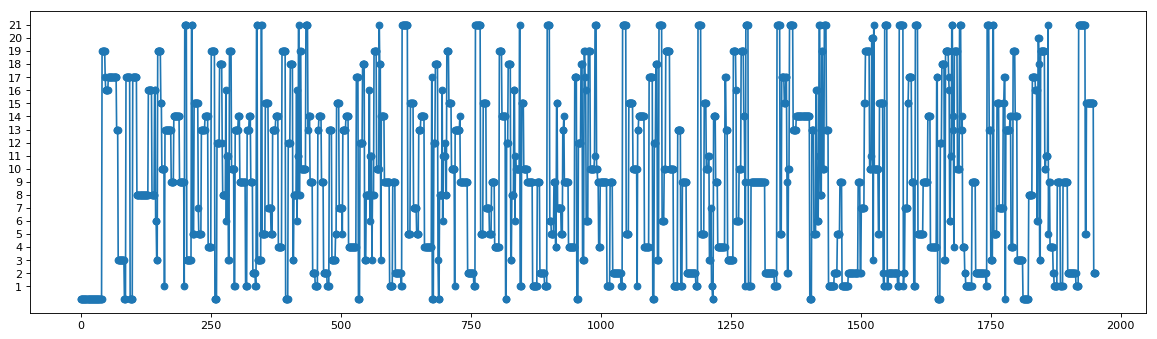

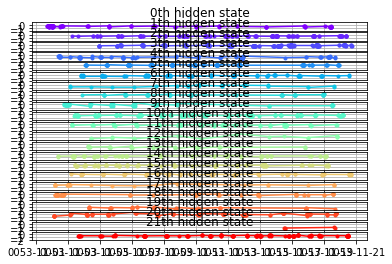

In [96]:
print("Transition matrix")
np.set_printoptions(precision=3, suppress=True)
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot( hidden_states, '-o')
plt.yticks(np.arange(1, 22, 1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%2.d'))
plt.show()

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(timestamp[mask], x[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
#     ax.xaxis.set_major_locator(YearLocator())
#     ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

In [205]:
joblib.dump(model, "test_hmm.pkl")

NameError: name 'joblib' is not defined